In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm
import math 
#import qutip as qt
from scipy.optimize import curve_fit

from scipy.stats import norm

import scipy.integrate as integrate

from scipy.signal import argrelextrema #Til opgave 2a
import seaborn

# local imports
from simulate_von_neumann import Xeuler_sim, p, cminus_VN, cplus_VN, phi

# set theme
seaborn.set_style('ticks')


# The von Neumann model

In this worksheet we will investigate weak measurement with a qubit system and a free particle as a meter. The hamiltonian is 

$$H=H_S\otimes1+1 \otimes H_M  + H_{SM} = \frac{\epsilon}{2} \hat{\sigma}_z \otimes \mathbf{1}+ \mathbf{1}\otimes \frac{\hat{p}^2}{2m} + g \delta(t)\hat{\sigma}_z \otimes \hat{p}$$

The system is analogue to light passing trough a birefringent crystal or a spin 1/2 particle in a single Stern Gerlach experiment. The meter system is treated as a photographic plate but the gaussian wave function is also common in more technical measurement devises like a quantum point contact. We first introduce the theoretical predictions learned from the Quantum Measurement book and thereafter the simulate the system using the stochastic master equation. 


## Theoretical overview

The state of the whole system is a direct product of the system state and the meter state $\ket{\Psi}=\ket{\psi}_S\otimes \ket{\phi}_M$. Instead of the classical collapse of a wave function using projective measurement, we have a partial collapse where it is only the meter that collapses to a state $\ket{x}_M$. Using the Heisenberg picture the state immediatly after the delta interaction at $t=0$ is 

$$\ket{\tilde{\Psi}}= \hat{U}_{SM}\ket{\tilde{\psi}}_S\otimes \ket{\tilde{\phi}}_M  = \exp(-ig\hat{\sigma}_z \otimes \hat{p}/\hbar)\ket{\tilde{\psi}}_S\otimes \ket{\tilde{\phi}}_M$$

Writing in terms of the basis of the system hamiltonian and recognizing the translation operator we get a measurement operator 

$$\Omega_x \equiv _M\langle x \mid \hat{U}_{SM} \ket{\tilde{\phi}}_M = \mid + \rangle_S \langle + \mid \phi(x-g) + \mid - \rangle_S \langle - \mid \phi(x+g)$$

Where the $\phi(x)$ is the position representation of the meter state:

$$\phi(x)=\braket{x \mid\phi} = \frac{1}{(2\pi \sigma^2)^{1/2}} \exp(-\frac{x^2}{4\sigma^2})$$

But through measurement $\braket{x \mid\phi} = \delta (t)$ right...? For measurement outcome $x$ the particle starting in  $\ket{\tilde{\psi}}=a\ket{+}+b\ket{-}$ is in state

$$P_x = \mid \mid \Omega_x \ket{\psi} \mid \mid^2$$
The meter starts in a eigenstate of the system $\phi(x)$ which is a gausian with center at the origin. The post measurement state will collaps the meter to the value $x$ and the system state s 

$$\ket{\psi'}= \frac{\Omega_x \ket{\psi}}{\mid \mid \Omega_x \ket{\psi} \mid \mid}$$

From the initial value of the system:

$$\ket{\tilde{\psi}}_S=a\ket{+}+b\ket{+}$$

Does the coeficients here depend of time...? They most have some wiggle factor

$$\ket{\tilde{\psi}}_S=\mathrm{e}^{-iH_st}(a_0\ket{+}+b_0\ket{-})$$


In [2]:
#Initial parameters for system and meter  
a0 = 1/(np.sqrt(2)) #system initial coefficient plus polarized 
b0 = np.sqrt(1-a0**2)#1/(np.sqrt(2)) #system initial coefficient mins polarized 
sigma = 1 #standard deviation of meter's initial wave function

X_span = np.linspace(-10,10,250)

gstrong = sigma*4 #much bigger than deviation of position 
gweak = sigma/4 #much bigger than deviation of position 

exp_x_strong = integrate.quad(lambda x: x*p(x,gstrong,a0,b0), -10, 10)[0]
exp_x_weak = integrate.quad(lambda x: x*p(x,gweak,a0,b0), -10, 10)[0]

#print(f"normalization: {exp_x_weak}, {exp_x_strong}")


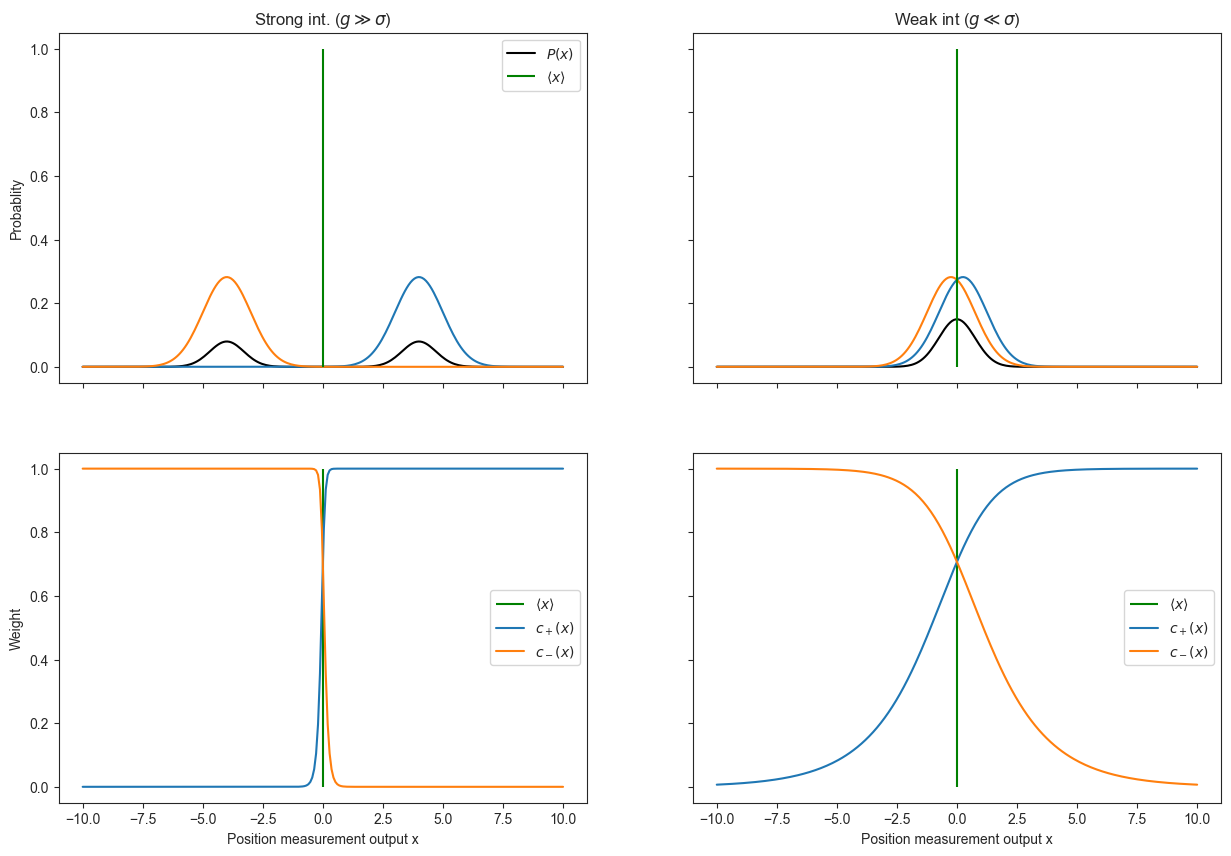

In [3]:
fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(15,10))

# set figsize

ax[0,0].set_title(f'Strong int. ($g\gg\sigma$)')
ax[0,0].plot(X_span,p(X_span,gstrong,a0,b0),color='Black',label=f'$P(x)$')
ax[0,0].plot(X_span,a0*phi(X_span-gstrong))
ax[0,0].plot(X_span,b0*phi(X_span+gstrong))
ax[0,0].vlines(exp_x_strong,0,1,label=r'$\langle x \rangle$',color='green')
ax[1,0].vlines(exp_x_strong,0,1,label=r'$\langle x \rangle$',color='green')

ax[1,0].plot(X_span,cplus_VN(X_span,gstrong,a0,b0),label = f'$c_+(x)$')
ax[1,0].plot(X_span,cminus_VN(X_span,gstrong,a0,b0),label = f'$c_-(x)$')

ax[1,0].set_xlabel('Position measurement output x')

ax[0,0].legend()
ax[1,0].legend()



ax[0,1].set_title(f'Weak int ($g\ll\sigma$)')
ax[0,1].plot(X_span,p(X_span,gweak,a0,b0),color='Black')
ax[0,1].plot(X_span,a0*phi(X_span-gweak))
ax[0,1].plot(X_span,b0*phi(X_span+gweak))

ax[0,1].vlines(exp_x_weak,0,1,label=r'$\langle x \rangle$',color='green')
ax[1,1].vlines(exp_x_weak,0,1,label=r'$\langle x \rangle$',color='green')

ax[1,1].plot(X_span,cplus_VN(X_span,gweak,a0,b0),label = f'$c_+(x)$')
ax[1,1].plot(X_span,cminus_VN(X_span,gweak,a0,b0),label = f'$c_-(x)$')

ax[0,0].set_ylabel('Probablity')
ax[1,0].set_ylabel('Weight')
ax[1,1].set_xlabel('Position measurement output x')


ax[1,1].legend()
plt.show()

Now the the simulaton we want to see the dynamics of a measurements, say the expectationvalue of x $\exp{x(t)}$. But since the system hamiltonian commutes with the interaction term, any measurement of the system will not change the state of the system - it is a . Two sequential measurements have the same possible measurement outcome as a single measurement. We therefore expect the expectation value of the position is constant:

In [128]:
#sanity check: integrate.quad(lambda x: p(x,gstrong,a,b), -10, 10)

## Random walk simulation using wavefunction (not mixed state) 

Now we will have multiple sequential measurements of the system, like having severial identical stern gerlach experiements/birefringent crystals. We take $N$ measurements with $\Delta t$ time inbetween each measurement. The i'th time step (with a weak measurement) will give us:

* Time step $t_j = t_{j-1}+\Delta t$
* Position measurement $x_i$ taken from the distribution $P(x,a_{i-1},b_{i-1})$.
* Post measurement state, by updating the coeficitens $$\ket{\psi_{j+1}}= \frac{\Omega_x \ket{\psi_j}}{\mid \mid \Omega_x \ket{\psi_j} \mid \mid}$$

Which ultimately will give us 3 lists $\{x_i\}, \{a_i\}, \{b_i\}$ through a time evolution t.  We *can* a Weiner process from a gausian - might not be important since we already draw x from a gaussian, but it might give a nice way to learn how to include other noise? 


In [4]:
N = 150 #Number of measurements per simulation
delta_t = 1 #time between each measurement, relative to system evolution (compare with epsiplon)
t_span = np.linspace(0,delta_t*N,N+1)

Now running N_sim simulations, calibrated so we see a steady state solution

In [5]:
r= 0#1/40 #Compare with the relaxation time, which is proportial to number of measurements before the two gaussian peaks are well seperated. For gweak =sigma* 1/4 this is after around 40 measurements...  

N_sim = 500 #number of simulations


X_ensembe_weak,a_ensembe_weak, b_ensembe_weak  = Xeuler_sim(N_sim, N,gweak, a0, b0,r)  #X_sim(N_sim,N,gweak,a0=a0,b0=b0)
Pa_ensembe_weak_mean = np.mean(a_ensembe_weak**2,axis=0)
Pb_ensembe_weak_mean = np.mean(b_ensembe_weak**2,axis=0)
X_ensembe_weak_mean = np.mean(X_ensembe_weak,axis=0)

X_ensembe_strong,a_ensembe_strong, b_ensembe_strong  = Xeuler_sim(N_sim,N,gstrong,a0,b0,r)
Pa_ensembe_strong_mean = np.mean(a_ensembe_strong**2,axis=0)
Pb_ensembe_strong_mean = np.mean(b_ensembe_strong**2,axis=0)

Now the strong is not that interesting. 

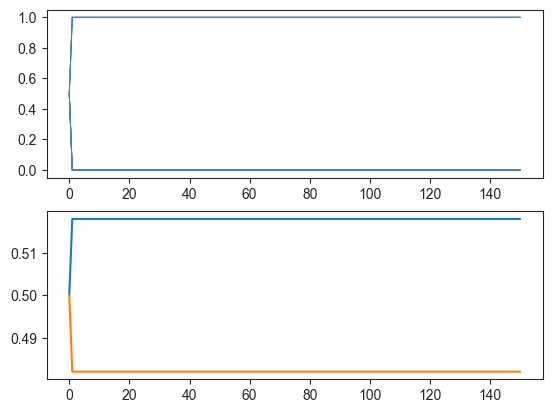

In [6]:
fig, ax = plt.subplots(2)

ax[0].plot(t_span,a_ensembe_strong[10]**2,linewidth=0.7,label = fr'$P_+(t)=\mid c_+(t)\mid^2$')
for i in a_ensembe_strong[:10]: ax[0].plot(t_span,i**2,color='steelblue',linewidth=0.7)

ax[1].plot(t_span,Pa_ensembe_strong_mean,label = r'$\langle P_+(t) \rangle$')
ax[1].plot(t_span,Pb_ensembe_strong_mean,label = r'$\langle P_-(t) \rangle$')
plt.show()

/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_1654/140756782.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0,1].legend()


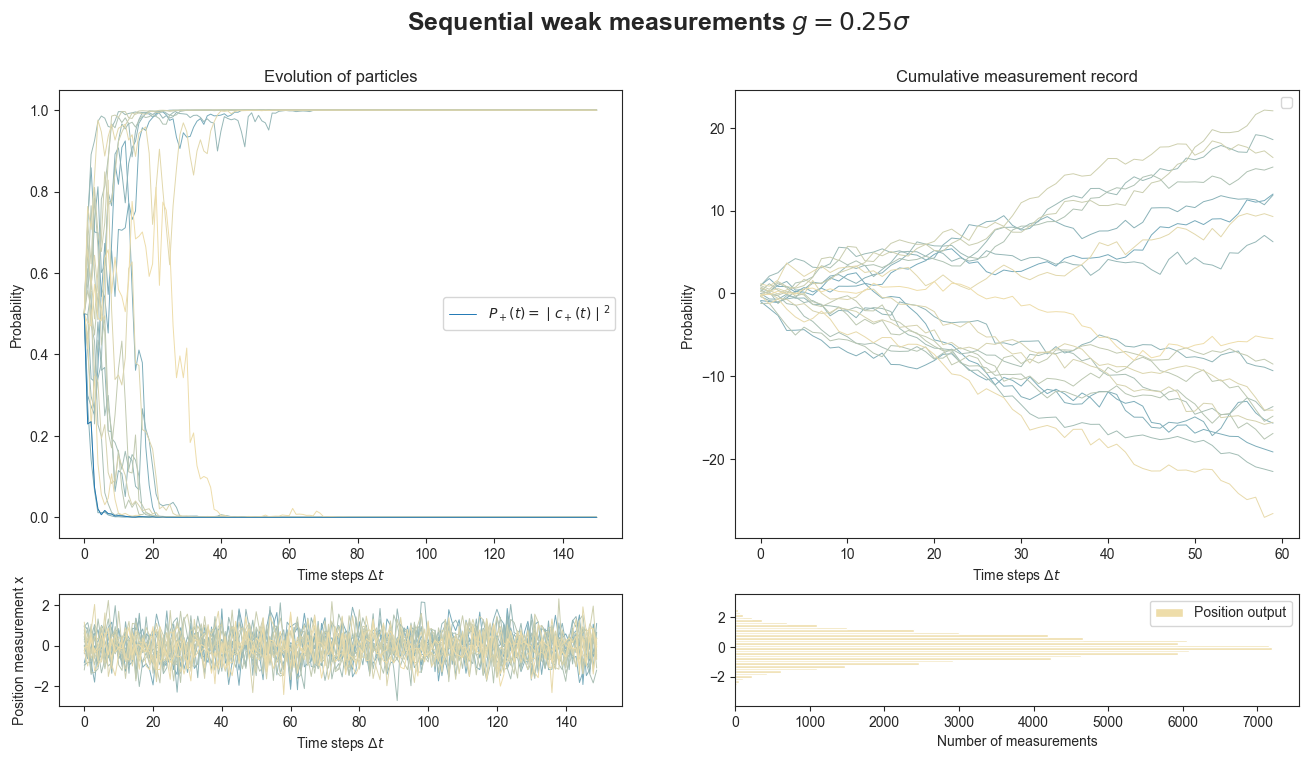

In [33]:
fig, ax = plt.subplots(2, 2,gridspec_kw={'height_ratios': [4,1]},figsize=(16,8))

plt.suptitle(fr'Sequential weak measurements $g={gweak/sigma}\sigma$', fontsize=18,fontweight="bold")

ax[0,0].set_xlabel(r"Time steps $\Delta t$");
ax[0,0].set_ylabel(r'Probability')

ax[1,0].set_xlabel(r"Time steps $\Delta t$");
ax[1,0].set_ylabel(r'Position measurement x')

ax[0,1].set_xlabel(r"Time steps $\Delta t$");
ax[0,1].set_ylabel(r'Probability ')

ax[1,1].set_xlabel(r"Number of measurements");

ax[0,0].set_title('Evolution of particles')
ax[0,1].set_title(f'Cumulative measurement record')

colors = seaborn.color_palette("blend:#7AB,#EDA", 20)
for i,a in enumerate(a_ensembe_weak[:20]): 
    ax[0,0].plot(t_span,a**2,color=colors[i],linewidth=0.7)
#for i in a_ensembe_strong: ax[0,0].plot(t_span,i,color = 'green',linewidth=0.7)

ax[0,0].plot(t_span,a_ensembe_weak[10]**2,linewidth=0.7,label = fr'$P_+(t)=\mid c_+(t)\mid^2$')
#ax[0,0].plot(t_span,a_ensembe_strong[10],color = 'green',linewidth=0.7,label = f'Strong measurement experiments g={gstrong}')

#plt.legend(loc='upper center', fancybox=True, shadow=True, ncol=2)

for i,x in enumerate(X_ensembe_weak[:20]): 
    ax[1,0].plot(t_span[:-1],x,color= colors[i],linewidth=0.7 )
#for i in X_ensembe_strong[:-1]: ax[1,0].plot(t_span[:-1],i,color = 'green',linewidth=0.7)

#ax[0,1].plot(t_span,Pa_ensembe_weak_mean,label = r'$\langle P_+(t) \rangle$')
#ax[0,1].plot(t_span,Pb_ensembe_weak_mean,label = r'$\langle P_-(t) \rangle$')
#colors = seaborn.color_palette("flare", 20)
for i in range(20): 
    ax[0,1].plot(t_span[:60],np.cumsum(X_ensembe_weak[i,:60]).T, color = colors[i],linewidth=0.7)


ax[1,1].hist(np.concatenate(X_ensembe_weak),bins=40,orientation='horizontal',color=colors[-1],label='Position output')

ax[0,0].legend()
ax[0,1].legend()
ax[1,1].legend()


plt.show()
#print(fr'$\sigma$ =%.2f'%(sigma))

#fig.savefig(f'figures/gweak{gweak}sigma_Nsim{N_sim}.pdf')

**What did we learn from these plots:** If the average the two weights for each time step, we will erase the information of what state we are in. We are unable to distinc the two gaussian distributions that are shifted from one another. We therefore want to look at the accumulated time instead for long term memory...   

plot the change of $a$ and $b$ density functions over time

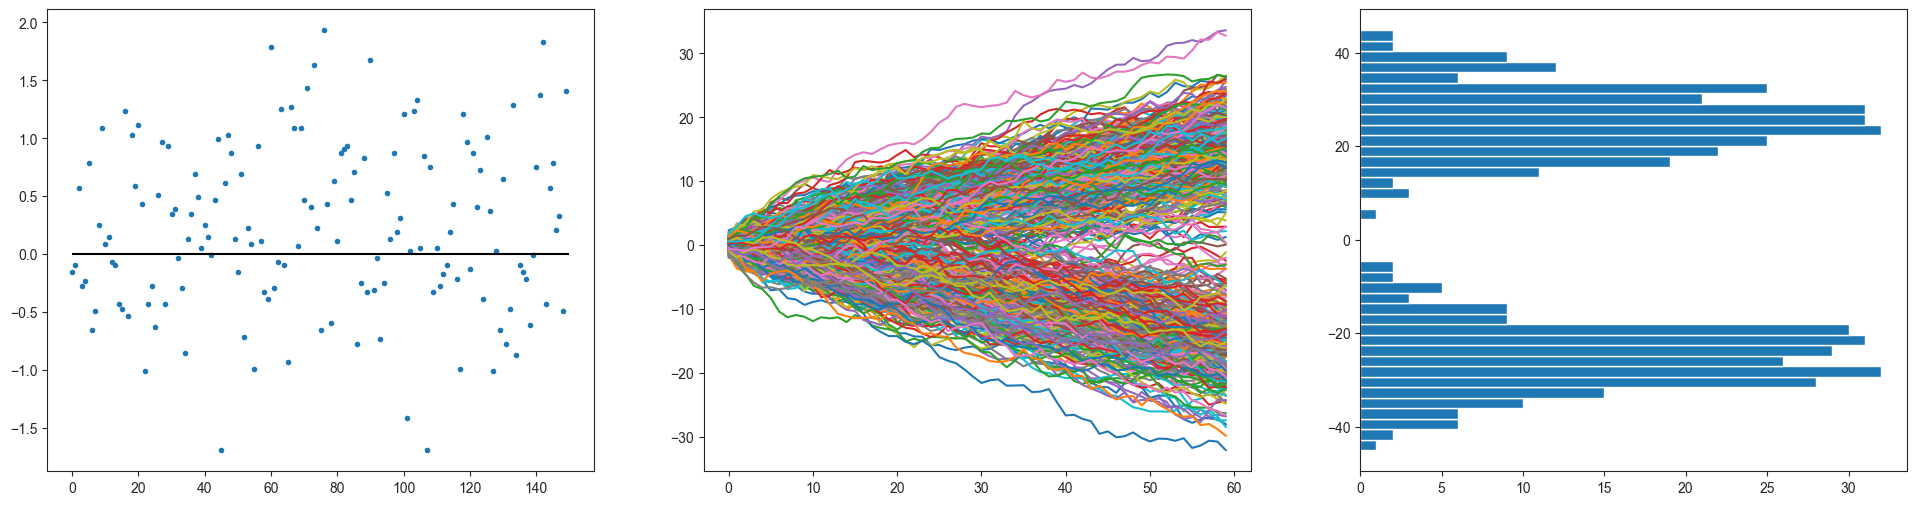

In [154]:
fig, ax = plt.subplots(1,3,figsize=(24,6))

ax[2].hist(X_ensembe_weak[:,:100].sum(axis=1),bins=40,orientation='horizontal')

ax[0].plot(t_span[:-1], X_ensembe_weak[0], '.')
ax[0].hlines(exp_x_weak,0,N,'black')

for i in range(N_sim): 
    ax[1].plot(t_span[:60],np.cumsum(X_ensembe_weak[i,:60]).T)



plt.show()

Bredden af gauss er prop med sqrt(N)(antal målinger), afstand ml målingerne er prop med N. 

Tag X postion for enkelt måling og forudse om tilstanden er 0 eller 1. lav supervised learning ved at feede med  x positioner hvor vi ved tilstanden er 0 (go derefter med 1)

MovieWriter ffmpeg unavailable; using Pillow instead.


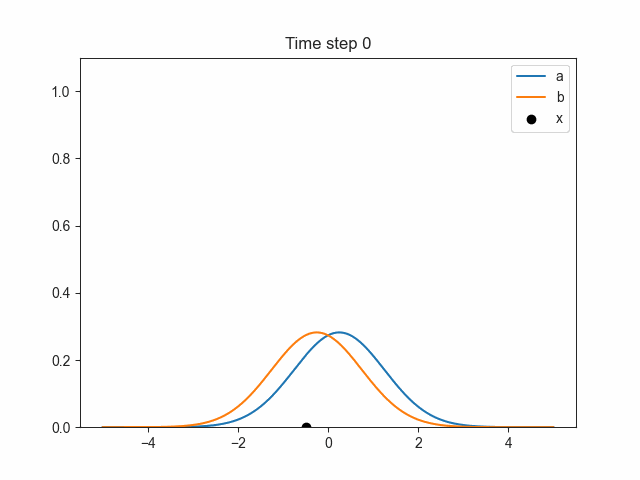

In [134]:
from matplotlib.animation import FuncAnimation
from IPython.display import Image

sim = np.random.randint(0,N_sim)
X_span = np.linspace(-5,5,250)

fig, ax = plt.subplots()
line1, = ax.plot(X_span, a0*phi(X_span-gweak), label = 'a')
line2, = ax.plot(X_span, b0*phi(X_span+gweak), label = 'b')
point = ax.scatter(X_ensembe_weak[sim,0],0,color = 'black', label = 'x')

plt.legend()
ax.set_ylim(0,1.1)

def animate(i):
    a = a_ensembe_weak[sim,i]
    b = b_ensembe_weak[sim,i]
    line1.set_ydata(a*phi(X_span-gweak))
    line2.set_ydata(b*phi(X_span+gweak))
    point.set_offsets([X_ensembe_weak[sim,i],0])
    ax.set_title(f"Time step {i}")

    return (line1, line2, point),



ani = FuncAnimation(fig = fig,func = animate, frames=np.arange(80), interval=1)
ani.save("movie.gif")
plt.close()

display(Image(data=open('movie.gif','rb').read(), format='png'))



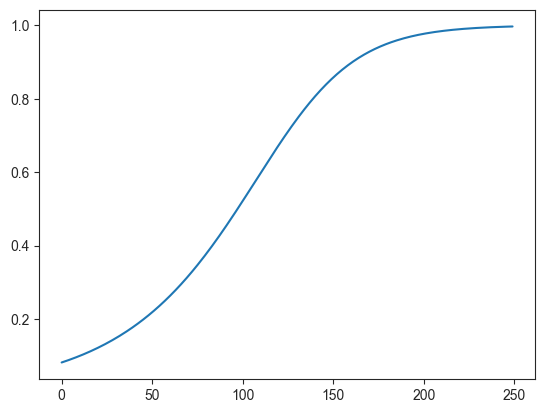

In [135]:

plt.plot(cplus_VN(X_span,gweak,a0,b0))

### True and realisable quantum trajectories

In the simluation above, we draw measurement record from the knowlegde of the current state $(a,b)$ coefficients, and then we can update the state, and repeat. But in real experiements, we only have the measurement output and not any running state lists! So here, we will try to use the measurement record to create other possible system states and compare with the original "true" that the data is drawn from... The question is whether we can actually tell the different realisations apart? 

We have a measurement record, N_sim values for each time step and we find the i'th

* Time step $t_j = t_{j-1}+\Delta t$
* We draw a value a_i from cplus(x_i,gweak,a0,b0) BUT we do not know the first state.... we might need to assume a given state to get started? The initial state (a0,b0) will shift the two functions to the side... 

* Position measurement $x_i$ taken from the distribution $P(x,a_{i-1},b_{i-1})$. We add a Weiner process from a gausian - might not be important since we already draw x from a gaussian, but it might give a nice way to learn how to include other noise?
* Post measurement state, by updating the coeficitens $$\ket{\psi_{j+1}}= \frac{\Omega_x \ket{\psi_j}}{\mid \mid \Omega_x \ket{\psi_j} \mid \mid}$$

Which ultimately will give us 3 lists $\{x_i\}, \{a_i\}, \{b_i\}$ through a time evolution t. 

In [136]:
a0,b0

(np.float64(0.7071067811865475), np.float64(0.7071067811865476))

ValueError: Expected 2D array, got 1D array instead:
array=[ 24.04404404 -29.66966967  23.3033033   27.56756757 -25.56556557
  18.23823824  31.45145145 -34.83483483 -22.36236236  34.39439439
  38.25825826 -28.64864865 -26.48648649  22.46246246  35.2952953
  23.5035035   20.34034034 -14.33433433  22.12212212  25.08508509
  24.84484484  28.30830831  19.75975976  17.37737738 -37.73773774
 -26.04604605  31.71171171  13.69369369 -25.28528529 -36.1961962
  16.4964965   31.89189189  30.33033033  28.28828829 -29.62962963
 -25.52552553  -5.88588589 -21.78178178 -26.42642643  36.73673674
 -22.74274274  15.13513514 -31.57157157 -22.4024024  -28.28828829
  21.94194194 -31.45145145 -19.17917918  23.1031031   32.45245245
 -41.48148148  25.00500501  18.8988989  -19.6996997  -32.75275275
  21.12112112 -29.54954955  28.48848849  18.13813814  33.17317317
 -31.43143143  28.52852853 -27.58758759 -10.11011011  26.12612613
 -21.26126126  16.63663664 -16.91691692 -18.71871872  18.53853854
  33.49349349 -11.51151151  19.77977978  22.42242242 -21.46146146
 -21.36136136 -15.0950951  -34.39439439 -25.76576577  24.36436436
  37.41741742 -21.36136136  27.26726727  27.26726727  29.28928929
  25.44544545  20.2002002   22.04204204  21.3013013   24.38438438
 -18.91891892 -19.23923924 -27.70770771  35.95595596 -19.97997998
  19.03903904 -28.84884885 -29.02902903 -33.79379379  18.81881882
 -22.06206206 -11.41141141 -21.34134134 -30.91091091 -40.54054054
  15.15515516  25.82582583 -25.38538539  21.22122122  27.56756757
 -29.46946947 -32.05205205  26.18618619  24.74474474  27.76776777
 -18.83883884 -14.47447447 -25.60560561 -15.85585586  22.32232232
  34.13413413  23.82382382 -21.32132132 -22.98298298 -32.69269269
  20.54054054 -20.8008008  -32.13213213  32.89289289 -27.32732733
  36.57657658 -26.30630631  13.55355355 -37.5975976  -14.59459459
  -6.12612613 -19.83983984 -26.72672673  38.91891892 -25.68568569
 -31.53153153  29.76976977  33.37337337  16.43643644  32.21221221
 -32.81281281  28.06806807  25.68568569  25.84584585  14.79479479
  27.92792793  27.90790791  25.78578579 -21.8018018  -29.02902903
  19.5995996   21.4014014  -35.13513514  33.49349349 -28.64864865
  27.66766767 -27.06706707  28.74874875 -14.67467467 -31.31131131
 -10.09009009  17.2972973   22.66266266  20.76076076 -40.38038038
  31.91191191 -22.68268268 -32.93293293  24.74474474 -28.22822823
 -19.43943944  16.1961962   23.34334334  36.21621622  25.84584585
 -21.04104104  19.43943944  15.85585586 -27.08708709  26.20620621
  27.98798799 -14.21421421 -16.63663664 -30.89089089 -27.22722723
  13.41341341 -22.94294294 -24.1041041   19.13913914 -28.72872873
 -20.76076076  38.45845846 -22.12212212  21.44144144 -27.88788789
  16.87687688  25.08508509  24.04404404 -18.35835836  41.96196196
 -27.52752753  -7.24724725  31.09109109  31.47147147 -42.24224224
  24.98498498 -27.16716717  21.5015015  -21.06106106  38.21821822
 -28.76876877  44.8048048  -27.92792793 -20.34034034 -30.43043043
 -21.24124124 -18.35835836  13.21321321 -22.08208208 -16.77677678
 -30.71071071  26.10610611 -23.88388388 -30.61061061  24.74474474
  14.07407407  25.72572573 -22.34234234  24.18418418 -29.88988989
 -21.18118118  17.53753754 -19.25925926  31.65165165 -23.6036036
  24.004004   -20.92092092 -17.17717718 -29.76976977  24.46446446
  24.36436436  10.67067067 -23.18318318 -28.52852853 -30.01001001
  38.37837838  18.17817818  20.3003003   34.61461461 -23.52352352
  23.08308308  30.99099099  22.3023023  -23.66366366  29.88988989
  26.74674675  16.55655656  25.48548549 -23.88388388  32.45245245
  29.32932933 -23.62362362 -24.86486486 -20.26026026 -19.45945946
  21.38138138  36.17617618  23.5035035   32.49249249 -19.81981982
  30.01001001 -20.06006006  31.29129129  24.28428428 -34.79479479
  29.28928929  38.27827828  -7.78778779 -39.55955956 -18.53853854
 -20.62062062 -28.06806807 -18.17817818 -15.85585586  18.7987988
 -28.14814815  28.72872873   9.96996997 -33.31331331  23.88388388
 -26.68668669 -20.96096096  17.45745746  18.55855856 -20.06006006
 -27.26726727  24.16416416  26.88688689  31.03103103 -19.81981982
  13.23323323 -31.55155155 -20.62062062  13.35335335  27.98798799
 -19.6996997  -29.66966967 -31.95195195 -23.78378378 -26.96696697
  20.64064064  17.61761762  20.42042042  32.79279279  23.22322322
  38.6986987   36.71671672 -30.63063063 -23.68368368  30.67067067
 -28.14814815 -28.50850851  35.85585586  29.16916917  26.64664665
 -45.08508509 -17.75775776  29.98998999  25.00500501 -20.48048048
  32.99299299 -22.74274274 -25.98598599 -24.32432432  23.5035035
  19.41941942 -19.7997998  -39.91991992 -35.87587588 -36.87687688
 -23.68368368  28.52852853 -26.02602603 -30.69069069 -20.5005005
  36.13613614  20.          33.59359359  42.88288288 -30.21021021
  28.20820821 -31.23123123 -23.72372372  22.76276276 -18.93893894
  30.49049049 -22.34234234  16.43643644  32.05205205  27.68768769
 -19.43943944 -26.36636637  40.2002002  -32.25225225 -23.58358358
  28.14814815  25.50550551  19.23923924 -22.62262262  23.22322322
  20.22022022  26.62662663  27.02702703 -31.03103103  30.59059059
 -31.35135135 -18.4984985  -33.31331331  28.70870871 -13.11311311
 -18.85885886 -10.43043043 -24.94494494  29.36936937  15.7957958
  23.84384384 -33.85385385  29.42942943  39.51951952  14.21421421
  38.03803804  36.05605606 -29.72972973 -16.93693694  15.8958959
 -28.94894895 -14.63463463 -25.02502503 -32.23223223 -23.8038038
  22.06206206  26.56656657 -21.04104104  22.96296296 -28.04804805
  21.84184184  26.94694695 -35.37537538  33.49349349  26.96696697
  30.95095095 -21.44144144 -28.30830831  32.29229229 -24.14414414
 -19.35935936 -26.04604605  21.48148148 -31.85185185  41.42142142
 -31.99199199 -35.47547548 -27.96796797   5.50550551 -18.81881882
 -27.54754755  30.39039039  17.2972973   27.34734735  26.52652653
  31.79179179  32.83283283  17.55755756 -15.87587588 -33.91391391
 -21.52152152  13.51351351 -37.07707708 -24.68468468  24.2042042
  16.91691692  27.90790791 -28.12812813 -29.94994995  17.51751752
 -19.31931932  28.52852853  24.42442442 -24.3043043  -38.35835836
 -25.40540541 -38.91891892  25.34534535  20.8008008   18.6986987
 -26.98698699  29.12912913 -23.22322322 -24.58458458  32.27227227
 -34.37437437  19.95995996 -10.81081081  37.13713714  18.11811812
  14.59459459 -28.64864865  34.89489489  21.08108108 -27.10710711
  25.42542543  17.87787788 -27.54754755  22.98298298  33.29329329
 -29.38938939 -36.85685686  26.26626627 -11.25125125 -24.06406406
 -22.72272272 -32.03203203   8.86886887 -16.31631632  32.89289289
  18.03803804  27.34734735  22.44244244 -24.6046046  -21.32132132
  23.16316316  24.86486486 -29.10910911 -17.71771772  27.00700701].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

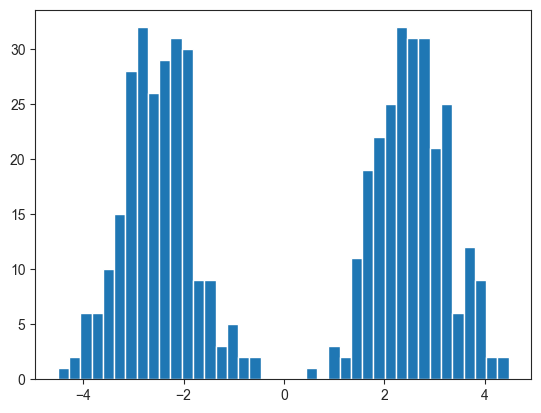

In [163]:
from sklearn.mixture import GaussianMixture


plt.hist(X_ensembe_weak[:,:100].sum(axis=1)/10,bins=40)


gm = GaussianMixture(n_components=2, random_state=0).fit(X_ensembe_weak[:,:100].sum(axis=1))


plt.plot(X_span,N_sim*p(X_span,2.5,a0,b0))

plt.xlim(-8, 8)



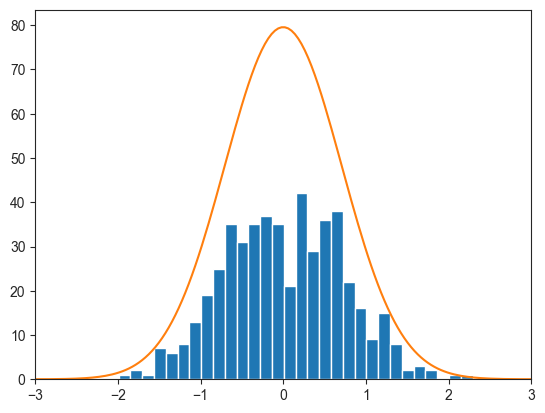

In [151]:
plt.hist(X_ensembe_weak[:,0],bins=30)
plt.plot(X_span,N_sim*p(X_span,0.01,a0,b0))

plt.xlim(-3, 3)


plt.show()

In [139]:
len(X_ensembe_weak[0,:])

150

In [140]:
def Realisable_sim(X,a0,b0,gweak)
    '''With measurement record X with N measurements and N_sim realisations, compute a (single?) possible quantum trajectory'''
    N = len(X_ensembe_weak[0,:]) #Number of measurement on single 
    N_sim = len

    af = np.zeros((N_sim, N+1)) #coeficitent in plus state
    bf = np.zeros((N_sim, N+1)) #coeficitent in minus state  

    #Initial conditions
    a[:,0] = np.repeat(a0,N_sim)
    b[:,0] = np.repeat(b0,N_sim)

    for i in range(N):#creating N_sim number of quantum trajectory in parallel
        P = p(X_span,g,a[:,i],b[:,i]) 
        P = P/P.sum(axis=1)[:,None]
        X[:, i] = np.array([np.random.choice(X_span,p=P[i,:]) for i in range(N_sim)])#Collect position measurement from the previus state, do not depend directly on the prevues position measurement!
        k = np.random.uniform(0,1) 
        if 0<k<r*delta_t:#bitflip!
            a[:,i+1] =  cminus_VN(X[:,i],g,a[:,i],b[:,i])
            b[:,i+1] = cplus_VN(X[:,i],g, a[:,i],b[:,i]) #Depends on initial state but next. Can it be complex from time evolution)?
        else:
            a[:,i+1] = cplus_VN(X[:,i],g, a[:,i],b[:,i]) #Depends on initial state but next. Can it be complex from time evolution)?
            b[:,i+1] = cminus_VN(X[:,i],g,a[:,i],b[:,i])
    return X,a,b

'''
def Xeuler_sim(N_sim, N, g, a0=1/np.sqrt(2) ,b0=None,r=0, delta_t=1):#

    Random walk with fixed step size, in a neaumann system. Can run multiple simulations at once.

    Input:
    N_sim: number of simulations
    N: number of measurements per simulation
    g: interaction strength
    a0: initial state coefficient plus
    b0: initial state coefficient minus
    r: rate for bit flip 

    Output:
    X: array with the particle position measurement at different time steps - measurement record.
    a: array with the particle state coefficient plus at different time steps.
    b: array with the particle state coefficient minus at different time steps.

    if b0 is None:
        b0 = np.sqrt(1 - a0**2)
        
    
    assert a0**2 + b0**2 == 1, 'Initial state coefficients do not sum to 1'
        
    
    X_span = np.linspace(-10,10,1000)
    
    X = np.zeros((N_sim, N)) #spot to plug in new position, one less measurement than states (starts and ends with states
    a = np.zeros((N_sim, N+1)) #coeficitent in plus state
    b = np.zeros((N_sim, N+1)) #coeficitent in minus state

    #Initial conditions
    a[:,0] = np.repeat(a0,N_sim)
    b[:,0] = np.repeat(b0,N_sim)

#    X[0] = #np.random.choice(X_span,p=p(X_span,gstrong,a[0],b[0])/p(X_span,gstrong,a[0],b[0]).sum()) #First measurement
    for i in range(N):#creating N_sim number of quantum trajectory in parallel
        P = p(X_span,g,a[:,i],b[:,i]) 
        P = P/P.sum(axis=1)[:,None]
        X[:, i] = np.array([np.random.choice(X_span,p=P[i,:]) for i in range(N_sim)])#Collect position measurement from the previus state, do not depend directly on the prevues position measurement!
        k = np.random.uniform(0,1) 
        if 0<k<r*delta_t:#bitflip!
            a[:,i+1] =  cminus_VN(X[:,i],g,a[:,i],b[:,i])
            b[:,i+1] = cplus_VN(X[:,i],g, a[:,i],b[:,i]) #Depends on initial state but next. Can it be complex from time evolution)?
        else:
            a[:,i+1] = cplus_VN(X[:,i],g, a[:,i],b[:,i]) #Depends on initial state but next. Can it be complex from time evolution)?
            b[:,i+1] = cminus_VN(X[:,i],g,a[:,i],b[:,i])
    return X,a,b
'''

SyntaxError: expected ':' (3599520581.py, line 1)

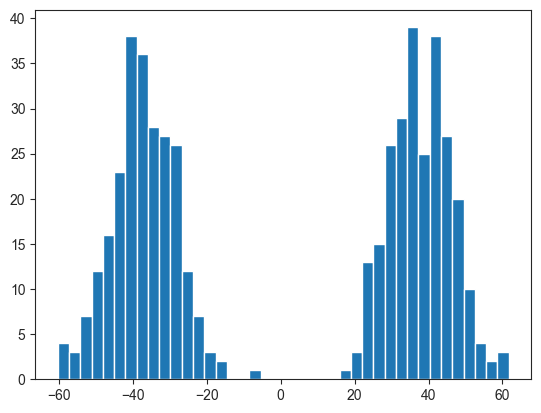

In [76]:
plt.hist(X_ensembe_weak[:].sum(axis=1),bins=40)
#plt.plot(X_span,a0*phi(X_span-gweak))
plt.show()